In [195]:
import os
import pandas as pd
from dotenv import load_dotenv
from a7 import A7Client

# Load environment variables
load_dotenv()

# Initialize A7 Client
client = A7Client(
    token=os.getenv("A7_API_TOKEN"),
    base_url=os.getenv("A7_BASE_URL", "https://a7.deutsche-boerse.com/api/")
)

print("A7 Client initialized.")

A7 Client initialized.


## 1. Define Target Instrument

We need to specify the market, date, and security we want to analyze.
For this example, we will use a **Xetra (XETR)** instrument.

*Note: You can use the `client.rdi` resource to discover these IDs dynamically.*

In [196]:
# Example parameters (Xetra, 2025-12-04 - Thursday)
MARKET_ID = "XETR"
DATE = 20251204
SEGMENT_ID = 52885
SECURITY_ID = 2504978

print(f"Target: {MARKET_ID} | Date: {DATE} | Security: {SECURITY_ID}")

Target: XETR | Date: 20251204 | Security: 2504978


## 2. Retrieve Order Book Snapshots

We use `client.orderbook.get_t7()` to fetch the order book.
We need a starting timestamp (`from_time`). If we don't have one, we can query `client.eobi` to find a transaction time.

In [197]:
# Step 2a: Find multiple transaction times to start from (get 10th time to skip early period)
try:
    times = client.eobi.get_transact_times(
        market_id=MARKET_ID,
        date=DATE,
        market_segment_id=SEGMENT_ID,
        security_id=SECURITY_ID,
        limit=100  # Get more times to choose from
    )
    
    if times:
        # Use a time from later in the list to start around 7:30 AM
        start_time = times[70] if len(times) > 70 else times[len(times)//2]
        print(f"Found {len(times)} transaction times")
        print(f"Using start time: {start_time}")
    else:
        print("No transaction times found. Using a default or failing.")
        start_time = None

except Exception as e:
    print(f"Error finding time: {e}")
    start_time = None

# Step 2b: Get the Order Book - request more snapshots to find one with data
if start_time:
    try:
        snapshots = client.orderbook.get_t7(
            market_id=MARKET_ID,
            date=DATE,
            market_segment_id=SEGMENT_ID,
            security_id=SECURITY_ID,
            from_time=start_time,
            limit=150,      # Get 150 snapshots (~1 hour of data)
            levels=10,      # Depth of 10 levels
            orderbook="aggregated",
            trades=True
        )
        
        print(f"Retrieved orderbook data")
        print(f"Type: {type(snapshots)}")
    except Exception as e:
        print(f"Error retrieving order book: {e}")
        snapshots = None

Found 100 transaction times
Using start time: 1764832626075539602
Retrieved orderbook data
Type: <class 'list'>


## 3. Analyze the Order Book

Let's inspect the structure of the returned snapshot. It typically contains `bids`, `asks`, and `trades`.

In [198]:
if snapshots:
    # Handle list response (when limit > 1)
    if isinstance(snapshots, list):
        snapshot = snapshots[0]
    else:
        snapshot = snapshots
    
    # Extract Bids (Buy) and Asks (Sell)
    bids = snapshot.get('Buy', [])
    asks = snapshot.get('Sell', [])
    
    print(f"Snapshot Time: {snapshot.get('TransactTime')}")
    print(f"Found {len(bids)} bid levels and {len(asks)} ask levels")
    
    # Create DataFrames for display
    # Prices are in scaled format (divide by 10^8 to get actual price)
    if bids:
        df_bids = pd.DataFrame(bids)
        df_bids.columns = ['Price', 'Quantity', 'Orders']
        # Convert to actual values (prices scaled by 10^8, quantity by 10^4)
        df_bids['Price'] = df_bids['Price'].astype(float) / 1e8
        df_bids['Quantity'] = df_bids['Quantity'].astype(float) / 1e4
        df_bids = df_bids.sort_values('Price', ascending=False)  # Highest bid first
    else:
        df_bids = pd.DataFrame(columns=['Price', 'Quantity', 'Orders'])
    
    if asks:
        df_asks = pd.DataFrame(asks)
        df_asks.columns = ['Price', 'Quantity', 'Orders']
        # Convert to actual values
        df_asks['Price'] = df_asks['Price'].astype(float) / 1e8
        df_asks['Quantity'] = df_asks['Quantity'].astype(float) / 1e4
        df_asks = df_asks.sort_values('Price', ascending=True)  # Lowest ask first
    else:
        df_asks = pd.DataFrame(columns=['Price', 'Quantity', 'Orders'])
    
    print("\n--- Top 5 Bids ---")
    print(df_bids.head())
    
    print("\n--- Top 5 Asks ---")
    print(df_asks.head())
    
    # Calculate spread
    if not df_bids.empty and not df_asks.empty:
        best_bid = df_bids['Price'].max()
        best_ask = df_asks['Price'].min()
        spread = best_ask - best_bid
        spread_bps = (spread / best_bid) * 10000
        print(f"\n--- Spread Analysis ---")
        print(f"Best Bid: €{best_bid:.2f}")
        print(f"Best Ask: €{best_ask:.2f}")
        print(f"Spread: €{spread:.2f}")
        print(f"Spread (bps): {spread_bps:.2f}")
else:
    print("No snapshots to analyze.")

Snapshot Time: 1764832626075539602
Found 10 bid levels and 10 ask levels

--- Top 5 Bids ---
   Price  Quantity  Orders
0  224.5      36.0       1
1  224.3      36.0       1
2  224.2      22.0       1
3  224.0       9.0       1
4  223.6      15.0       1

--- Top 5 Asks ---
   Price  Quantity  Orders
0  225.1      36.0       1
1  225.3      36.0       1
2  230.0     342.0       1
3  232.0    2000.0       1
4  233.0      50.0       1

--- Spread Analysis ---
Best Bid: €224.50
Best Ask: €225.10
Spread: €0.60
Spread (bps): 26.73


## 4. Visualization

A simple visualization of the order book shape (Price vs Quantity).

## 4. Process Multiple Snapshots

Let's analyze multiple snapshots over time to see order book evolution.

**Note:** This analysis processes approximately 1 hour of trading data from the morning session (starting around 07:30 CET).

In [199]:
# Process multiple snapshots to get richer data
all_snapshots_data = []

if isinstance(snapshots, list):
    # Process every 3rd snapshot to get ~2 minute intervals
    for i, snap in enumerate(snapshots[::3]):  # Take every 3rd snapshot for better spacing
        snap_data = {
            'snapshot_idx': i,
            'time': snap.get('TransactTime'),
            'bids': snap.get('Buy', []),
            'asks': snap.get('Sell', []),
            'trades': snap.get('Trades', [])
        }
        all_snapshots_data.append(snap_data)
    
    print(f"Processed {len(all_snapshots_data)} snapshots for visualization")
    print(f"Time range: {all_snapshots_data[0]['time']} to {all_snapshots_data[-1]['time']}")
else:
    all_snapshots_data.append({
        'snapshot_idx': 0,
        'time': snapshots.get('TransactTime'),
        'bids': snapshots.get('Buy', []),
        'asks': snapshots.get('Sell', []),
        'trades': snapshots.get('Trades', [])
    })
    print("Single snapshot processed")

Processed 50 snapshots for visualization
Time range: 1764832626075539602 to 1764835155567650474


## 5. Enhanced Visualizations

Create multiple visualizations showing order book depth, evolution, and market microstructure.

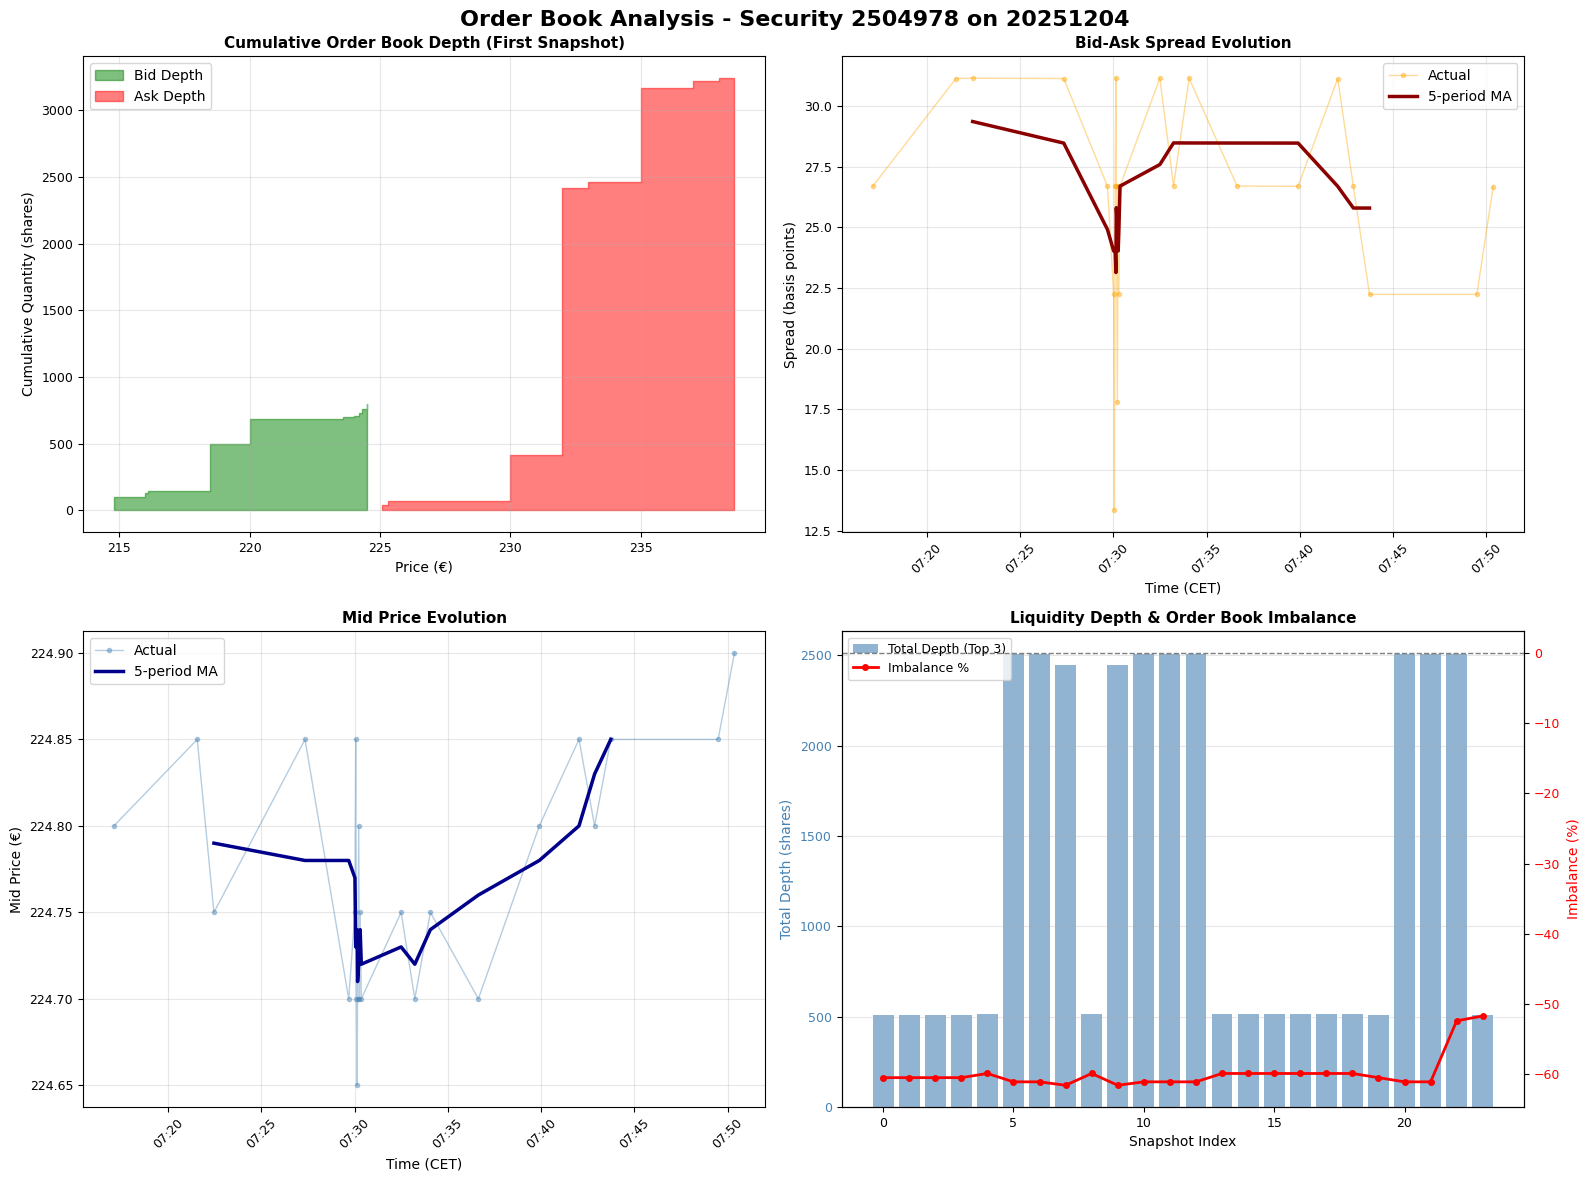


=== Order Book Statistics ===
Snapshots analyzed: 50
Time period: 08:17:06 - 08:50:21 CET
Duration: 33.3 minutes

--- Spread Analysis (basis points) ---
Average Spread: 26.32 bps
Median Spread: 26.70 bps
Min Spread: 13.34 bps
Max Spread: 31.16 bps
Std Dev: 4.43 bps

--- Price Movement ---
Starting Mid Price: €224.80
Ending Mid Price: €224.90
Price Change: €0.10 (0.04%)
Price Range: €224.65 - €224.90
Volatility (std): €0.07

--- Liquidity Analysis ---
Average Top-3 Depth: 1339 shares
Min Depth: 508 shares
Max Depth: 2508 shares

--- Order Book Imbalance ---
Average Imbalance: -59.83%
Periods with Bid Pressure: 0 (0.0%)
Periods with Ask Pressure: 24 (100.0%)


In [200]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Order Book Analysis - Security {SECURITY_ID} on {DATE}', fontsize=16, fontweight='bold')

# 1. Cumulative Depth Chart (First Snapshot)
if all_snapshots_data and all_snapshots_data[0]['bids'] and all_snapshots_data[0]['asks']:
    first_snap = all_snapshots_data[0]
    
    # Process bids
    bid_prices = [float(b['Price']) / 1e8 for b in first_snap['bids']]
    bid_qtys = [float(b['Quantity']) / 1e4 for b in first_snap['bids']]
    bid_df = pd.DataFrame({'price': bid_prices, 'qty': bid_qtys}).sort_values('price')
    bid_df['cumulative'] = bid_df['qty'].cumsum()
    
    # Process asks
    ask_prices = [float(a['Price']) / 1e8 for a in first_snap['asks']]
    ask_qtys = [float(a['Quantity']) / 1e4 for a in first_snap['asks']]
    ask_df = pd.DataFrame({'price': ask_prices, 'qty': ask_qtys}).sort_values('price')
    ask_df['cumulative'] = ask_df['qty'].cumsum()
    
    # Plot cumulative depth
    ax1.fill_between(bid_df['price'], 0, bid_df['cumulative'], color='green', alpha=0.5, label='Bid Depth', step='post')
    ax1.fill_between(ask_df['price'], 0, ask_df['cumulative'], color='red', alpha=0.5, label='Ask Depth', step='post')
    ax1.set_xlabel('Price (€)', fontsize=10)
    ax1.set_ylabel('Cumulative Quantity (shares)', fontsize=10)
    ax1.set_title('Cumulative Order Book Depth (First Snapshot)', fontsize=11, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', labelsize=9)

# 2. Spread Evolution Over Time (in Basis Points with smoothing)
spreads = []
spread_bps = []
mid_prices = []
times_ns = []
total_depth = []

for snap_data in all_snapshots_data:
    if snap_data['bids'] and snap_data['asks']:
        best_bid = max([float(b['Price']) / 1e8 for b in snap_data['bids']])
        best_ask = min([float(a['Price']) / 1e8 for a in snap_data['asks']])
        spread = best_ask - best_bid
        mid = (best_bid + best_ask) / 2
        
        # Calculate spread in basis points
        spread_bp = (spread / mid) * 10000 if mid > 0 else 0
        
        # Calculate total depth (top 3 levels)
        bid_depth = sum([float(b['Quantity']) / 1e4 for b in snap_data['bids'][:3]])
        ask_depth = sum([float(a['Quantity']) / 1e4 for a in snap_data['asks'][:3]])
        
        spreads.append(spread)
        spread_bps.append(spread_bp)
        mid_prices.append(mid)
        times_ns.append(int(snap_data['time']))
        total_depth.append(bid_depth + ask_depth)

if spread_bps:
    times_dt = [pd.to_datetime(t, unit='ns', utc=True).tz_convert('Europe/Berlin') for t in times_ns]
    
    # Filter outliers (cap at 99th percentile for better visualization)
    spread_bps_arr = np.array(spread_bps)
    percentile_99 = np.percentile(spread_bps_arr, 99)
    spread_bps_capped = np.minimum(spread_bps_arr, percentile_99)
    
    # Plot with both raw and smoothed data
    ax2.plot(times_dt, spread_bps_capped, marker='o', color='orange', alpha=0.4, 
             linewidth=1, markersize=3, label='Actual')
    
    # Add moving average if we have enough points
    if len(spread_bps_capped) >= 5:
        window = min(5, len(spread_bps_capped))
        spread_ma = pd.Series(spread_bps_capped).rolling(window=window, center=True).mean()
        ax2.plot(times_dt, spread_ma, color='darkred', linewidth=2.5, label=f'{window}-period MA')
    
    ax2.set_xlabel('Time (CET)', fontsize=10)
    ax2.set_ylabel('Spread (basis points)', fontsize=10)
    ax2.set_title('Bid-Ask Spread Evolution', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax2.tick_params(axis='x', rotation=45, labelsize=9)
    ax2.tick_params(axis='y', labelsize=9)

# 3. Mid Price Evolution with smoothing
if mid_prices:
    ax3.plot(times_dt, mid_prices, marker='o', color='steelblue', alpha=0.4, 
             linewidth=1, markersize=3, label='Actual')
    
    # Add moving average
    if len(mid_prices) >= 5:
        window = min(5, len(mid_prices))
        price_ma = pd.Series(mid_prices).rolling(window=window, center=True).mean()
        ax3.plot(times_dt, price_ma, color='darkblue', linewidth=2.5, label=f'{window}-period MA')
    
    ax3.set_xlabel('Time (CET)', fontsize=10)
    ax3.set_ylabel('Mid Price (€)', fontsize=10)
    ax3.set_title('Mid Price Evolution', fontsize=11, fontweight='bold')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax3.tick_params(axis='x', rotation=45, labelsize=9)
    ax3.tick_params(axis='y', labelsize=9)

# 4. Liquidity Depth Evolution (instead of just imbalance)
if total_depth and times_dt:
    # Create twin axis for imbalance
    ax4_twin = ax4.twinx()
    
    # Plot total depth as bars
    ax4.bar(range(len(total_depth)), total_depth, color='steelblue', alpha=0.6, label='Total Depth (Top 3)')
    ax4.set_xlabel('Snapshot Index', fontsize=10)
    ax4.set_ylabel('Total Depth (shares)', fontsize=10, color='steelblue')
    ax4.tick_params(axis='y', labelcolor='steelblue', labelsize=9)
    ax4.tick_params(axis='x', labelsize=9)
    
    # Plot imbalance on secondary axis
    imbalances = []
    for snap_data in all_snapshots_data:
        if snap_data['bids'] and snap_data['asks']:
            bid_total = sum([float(b['Quantity']) / 1e4 for b in snap_data['bids']])
            ask_total = sum([float(a['Quantity']) / 1e4 for a in snap_data['asks']])
            total = bid_total + ask_total
            if total > 0:
                imbalance = (bid_total - ask_total) / total * 100
                imbalances.append(imbalance)
            else:
                imbalances.append(0)
    
    ax4_twin.plot(range(len(imbalances)), imbalances, color='red', linewidth=2, 
                  marker='o', markersize=4, label='Imbalance %')
    ax4_twin.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax4_twin.set_ylabel('Imbalance (%)', fontsize=10, color='red')
    ax4_twin.tick_params(axis='y', labelcolor='red', labelsize=9)
    
    ax4.set_title('Liquidity Depth & Order Book Imbalance', fontsize=11, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add legends
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

# Print enhanced statistics
print("\n=== Order Book Statistics ===")
print(f"Snapshots analyzed: {len(all_snapshots_data)}")
print(f"Time period: {times_dt[0].strftime('%H:%M:%S')} - {times_dt[-1].strftime('%H:%M:%S')} CET")
print(f"Duration: {(times_dt[-1] - times_dt[0]).total_seconds()/60:.1f} minutes")

if spread_bps:
    print(f"\n--- Spread Analysis (basis points) ---")
    print(f"Average Spread: {np.mean(spread_bps):.2f} bps")
    print(f"Median Spread: {np.median(spread_bps):.2f} bps")
    print(f"Min Spread: {np.min(spread_bps):.2f} bps")
    print(f"Max Spread: {np.max(spread_bps):.2f} bps")
    print(f"Std Dev: {np.std(spread_bps):.2f} bps")

if mid_prices:
    print(f"\n--- Price Movement ---")
    print(f"Starting Mid Price: €{mid_prices[0]:.2f}")
    print(f"Ending Mid Price: €{mid_prices[-1]:.2f}")
    print(f"Price Change: €{mid_prices[-1] - mid_prices[0]:.2f} ({((mid_prices[-1]/mid_prices[0])-1)*100:.2f}%)")
    print(f"Price Range: €{min(mid_prices):.2f} - €{max(mid_prices):.2f}")
    print(f"Volatility (std): €{np.std(mid_prices):.2f}")

if total_depth:
    print(f"\n--- Liquidity Analysis ---")
    print(f"Average Top-3 Depth: {np.mean(total_depth):.0f} shares")
    print(f"Min Depth: {np.min(total_depth):.0f} shares")
    print(f"Max Depth: {np.max(total_depth):.0f} shares")

if imbalances:
    print(f"\n--- Order Book Imbalance ---")
    print(f"Average Imbalance: {np.mean(imbalances):.2f}%")
    print(f"Periods with Bid Pressure: {sum(1 for x in imbalances if x > 0)} ({sum(1 for x in imbalances if x > 0)/len(imbalances)*100:.1f}%)")
    print(f"Periods with Ask Pressure: {sum(1 for x in imbalances if x < 0)} ({sum(1 for x in imbalances if x < 0)/len(imbalances)*100:.1f}%)")

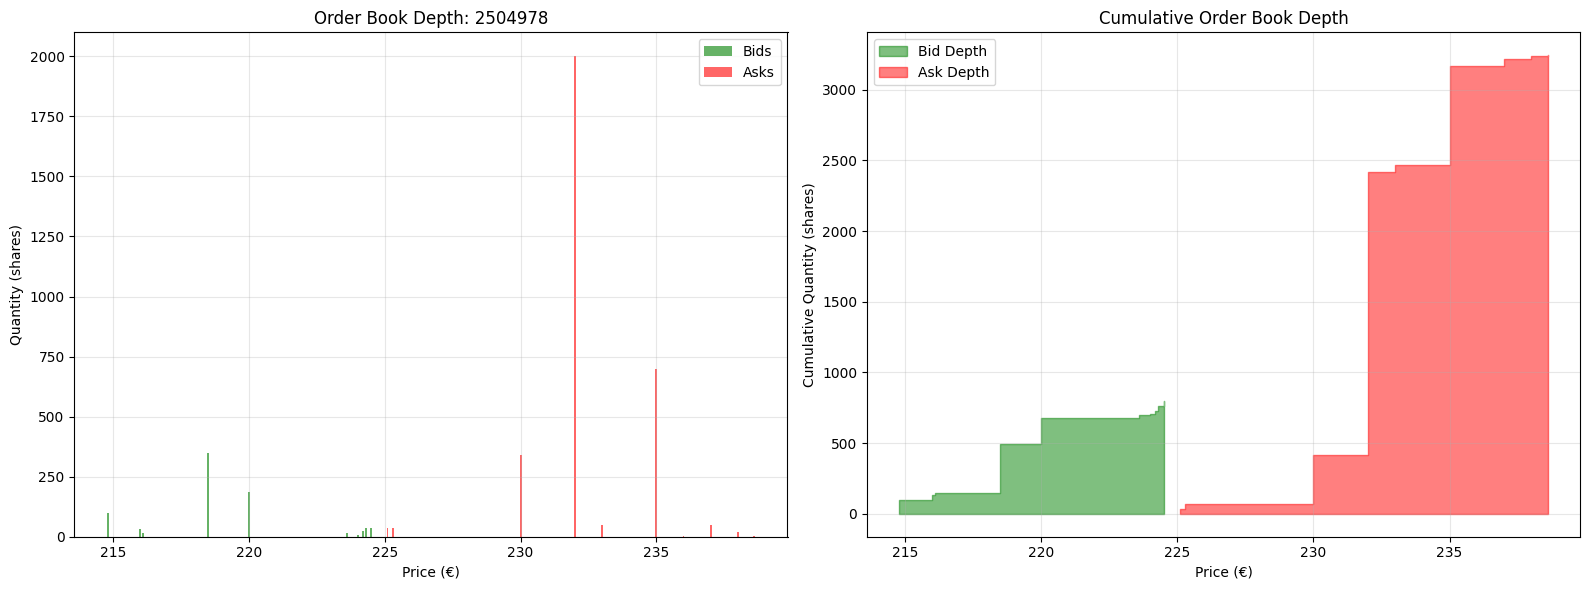

In [201]:
import matplotlib.pyplot as plt

if snapshots and not df_bids.empty and not df_asks.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Bar chart with proper width
    price_range = max(df_bids['Price'].max(), df_asks['Price'].max()) - min(df_bids['Price'].min(), df_asks['Price'].min())
    bar_width = price_range * 0.003  # 0.3% of price range
    
    ax1.bar(df_bids['Price'], df_bids['Quantity'], color='green', alpha=0.6, label='Bids', width=bar_width)
    ax1.bar(df_asks['Price'], df_asks['Quantity'], color='red', alpha=0.6, label='Asks', width=bar_width)
    ax1.set_title(f"Order Book Depth: {SECURITY_ID}")
    ax1.set_xlabel("Price (€)")
    ax1.set_ylabel("Quantity (shares)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right: Cumulative depth chart
    df_bids_sorted = df_bids.sort_values('Price')
    df_asks_sorted = df_asks.sort_values('Price')
    df_bids_sorted['cumulative'] = df_bids_sorted['Quantity'].cumsum()
    df_asks_sorted['cumulative'] = df_asks_sorted['Quantity'].cumsum()
    
    ax2.fill_between(df_bids_sorted['Price'], 0, df_bids_sorted['cumulative'], 
                     color='green', alpha=0.5, label='Bid Depth', step='post')
    ax2.fill_between(df_asks_sorted['Price'], 0, df_asks_sorted['cumulative'], 
                     color='red', alpha=0.5, label='Ask Depth', step='post')
    ax2.set_title("Cumulative Order Book Depth")
    ax2.set_xlabel("Price (€)")
    ax2.set_ylabel("Cumulative Quantity (shares)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()